In [39]:
import numpy as np
import jax.numpy as jnp
import torch
import time
import matplotlib.pyplot as plt
import plotfancy as pf

pf.housestyle_rcparams()

import torch.nn as nn
import torch.utils.data as data
from matplotlib.colors import to_rgba
from torch import Tensor
from tqdm.notebook import tqdm  # Progress bar

torch.manual_seed(42)  # Setting the seed


In [19]:
### - basic work with tensors on torch - ###
x = torch.arange(3, dtype=torch.float32, requires_grad=True) 
a = x + 2
b = a**2
c = b + 3
y = c.mean()
print("Y", y)
y.backward()
print(x.grad)

Y tensor(12.6667, grad_fn=<MeanBackward0>)
tensor([1.3333, 2.0000, 2.6667])


In [29]:
### - making the stuff work on mac gpu backend - ###
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
x = torch.zeros(2, 3)
x = x.to(device)

In [30]:
### - basic module template - ###
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        # Some init for my module
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

In [33]:
### let's build a simple classifier - ###
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)
# Printing the model lists all submodules it contains. The parameters of a module can be 
# obtained by using its parameters() functions, or named_parameters() to get a name 
# to each parameter object.
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [34]:
### - now let's put some data through the simple classifier - ### 
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        """XORDataset.

        Args:
            size: Number of data points we want to generate
            std: Standard deviation of the noise (see generate_continuous_xor function)

        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.9538, 0.1420]), tensor(1))


(<Figure size 400x300 with 2 Axes>,
 <Axes: title={'center': 'Dataset Samples'}, xlabel='$x_1$', ylabel='$x_2$'>)

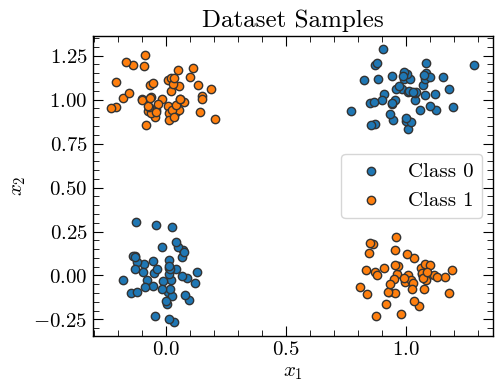

In [41]:
### - having a look at the data - ###
def visualize_samples(data, label):
    if isinstance(data, Tensor):
        data = data.cpu().numpy()
    if isinstance(label, Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig, ax1 = pf.create_plot(size=(4,3))
    ax1.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    ax1.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    ax1.set_title("Dataset Samples")
    ax1.set_ylabel(r"$x_2$")
    ax1.set_xlabel(r"$x_1$")
    ax1.legend()
    pf.fix_plot([ax1])
    return fig,ax1

visualize_samples(dataset.data, dataset.label)

In [52]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)
data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)


Data inputs torch.Size([8, 2]) 
 tensor([[ 0.9519, -0.0990],
        [-0.2048,  1.1001],
        [ 0.9091,  1.0313],
        [-0.0174,  1.0030],
        [ 0.8763, -0.2302],
        [ 0.9029,  1.2861],
        [ 0.9157, -0.1641],
        [ 0.0141,  0.0071]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 1, 1, 0, 1, 0])


### Optimization
After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients
6. We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

We are going to use binary cross entropy as our loss function. It is defined as 
\begin{equation}
\mathscr{L}_{BCE} = - \sum_i[y_i \log (x_i) + (1-y_i) \log (1-x_i)] 
\end{equation}
where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. We use the built in `nn.BCEWithLogitsLoss()}` as it has a built-in sigmoid. Recall that the sigmoid squashes all real numbers between 0 and 1 such that 
\begin{equation}
\sigma(x)= \frac{1}{1+e^{-x}}
\end{equation}
For updating the parameters, PyTorch provides the package torch.optim that has most popular optimizers implemented. We will for now use the simplest of them: `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss.

In [53]:
loss_module = nn.BCEWithLogitsLoss()
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Training

In [56]:
### - setting up a slightly bigger chunk of data to train from - ###
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
model.to(device) # push to mac gpu

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [57]:
### defining a training function to do the training loop ###

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            # Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 5: Update the parameters
            optimizer.step()

train_model(model, optimizer, train_data_loader, loss_module)
state_dict = model.state_dict()
torch.save(state_dict, "our_model.tar")
print(state_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict({'linear1.weight': tensor([[ 1.5807, -0.7550],
        [ 0.7348, -1.2397],
        [-1.5962, -2.0554],
        [ 1.7689, -2.3721]], device='mps:0'), 'linear1.bias': tensor([ 0.1049, -0.7485,  0.2998, -0.9729], device='mps:0'), 'linear2.weight': tensor([[-1.8624,  0.5923, -2.4051,  2.0572]], device='mps:0'), 'linear2.bias': tensor([0.3090], device='mps:0')})


### Evaluation
Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.




In [58]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)


When evaluating the model, we don’t need to keep track of the computation graph as we don’t intend to calculate the gradients. This reduces the required memory and speed up the model. In PyTorch, we can deactivate the computation graph using with `torch.no_grad(): ....` Remember to additionally set the model to eval mode.

In [59]:
def eval_model(model, data_loader):
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0 * acc:4.2f}%")

eval_model(model, test_data_loader)


Accuracy of the model: 100.00%


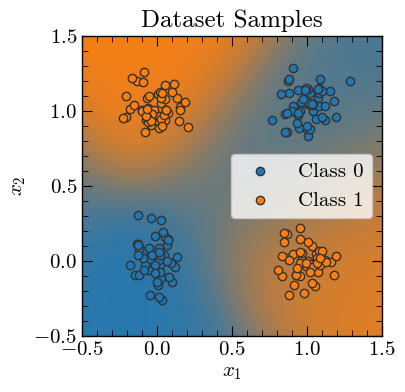

In [63]:
@torch.no_grad()  # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    
    if isinstance(data, Tensor):
        data = data.cpu().numpy()
    if isinstance(label, Tensor):
        label = label.cpu().numpy()
    
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig, ax1 = pf.create_plot(size=(4,3))
    ax1.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    ax1.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    ax1.set_title("Dataset Samples")
    ax1.set_ylabel(r"$x_2$")
    ax1.set_xlabel(r"$x_1$")
    ax1.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = Tensor(to_rgba("C0")).to(device)
    c1 = Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    # Specifying "None" in a dimension creates a new one
    output_image = (1 - preds) * c0[None, None] + preds * c1[None, None]
    output_image = (
        output_image.cpu().numpy()
    )  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    ax1.imshow(output_image, origin="lower", extent=(-0.5, 1.5, -0.5, 1.5))
    
    pf.fix_plot([ax1])


visualize_classification(model, dataset.data, dataset.label)
plt.show()